In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import pickle


In [2]:
dataset_dir = 'dataset/our_data'

datasets = os.listdir(dataset_dir)
datasets_df = pd.DataFrame({'filenames': datasets})

In [34]:
datasets_df

,filenames
0,neutral_jonathan1.csv
1,learning_johnpaul1.csv
2,.DS_Store
3,concentrating_jonathan1.csv
4,not_learning_johnpaul1.csv


In [3]:
def transform_set(scalar, data, fit=False):
    original_shape = data.shape 
    reshaped = data.reshape(-1, data.shape[-1]) 

    if fit:
        reshaped = scalar.fit_transform(reshaped)
    else:
        reshaped = scalar.transform(reshaped)
        
    reshaped = reshaped.reshape(original_shape)

    return reshaped

In [4]:
def preprocess():

    classes = ['concentrating', 'neutral']#, 'relaxed']
    datasets_by_class = {'concentrating':[], 'neutral':[]}
    test_sets_by_class = {'concentrating':[], 'neutral':[]}
    window_size = 256 #samples


    for class_name in classes:
        datasets = datasets_df[datasets_df['filenames'].str.contains(class_name)]

        for filename in datasets['filenames']:
            sub_df = pd.read_csv(f"{dataset_dir}/{filename}") 
            cutoff = int(sub_df.shape[0]*0.85)
            train_raw, test_raw = sub_df.iloc[:cutoff], sub_df.iloc[cutoff:]#train_test_split(sub_df, test_size=0.2, random_state=42, shuffle=False)
            # train_raw, test_raw = train_test_split(sub_df, test_size=0.2, shuffle=True)
            # train_raw = shuffle(train_raw)
            # test_raw = shuffle(test_raw)


            # NOTE: Split the data after reading, THEN perform sliding window
            
            # TRAINING DATA
            train_windows = []
            cur_window = []
            sample_count = 0

            row=0
            while row < train_raw.shape[0]:
                sample_count+=1
                cur_window.append(train_raw.iloc[row])

                if sample_count == window_size:
                    train_windows.append(cur_window)
                    cur_window = []
                    sample_count = 0
                    row-=int(window_size*0.8)

                row+=1

            # TEST DATA
            test_windows = []
            cur_window = []
            sample_count = 0

            row=0
            while row < test_raw.shape[0]:
                sample_count+=1
                cur_window.append(test_raw.iloc[row])

                if sample_count == window_size:
                    test_windows.append(cur_window)
                    cur_window = []
                    sample_count = 0
                    row-=int(window_size*0.8)

                row+=1

            # duplicates = 0
            # for u in train_windows:
            #     for v in test_windows:
            #         if np.array_equal(u,v):
            #             duplicates+=1

            # print(duplicates)


            datasets_by_class[class_name]+=train_windows
            test_sets_by_class[class_name]+=test_windows
        
    concentrating_train_data = np.asarray(datasets_by_class['concentrating'], dtype='object')
    neutral_train_data = np.asarray(datasets_by_class['neutral'], dtype='object')

    concentrating_test_data = np.asarray(test_sets_by_class['concentrating'], dtype='object')
    neutral_test_data = np.asarray(test_sets_by_class['neutral'], dtype='object')


    X_train = concentrating_train_data[:, :, 1:5]  # Remove the first column
    X_train = np.concatenate([X_train, neutral_train_data[:, :, 1:5]], axis=0)

    X_test = concentrating_test_data[:, :, 1:5]  # Remove the first column
    X_test = np.concatenate([X_test, neutral_test_data[:, :, 1:5]], axis=0)


    y_train = np.array([0] * concentrating_train_data[:, :, 1:5].shape[0] + [1] * neutral_train_data[:, :, 1:5].shape[0])
    y_test = np.array([0] * concentrating_test_data[:, :, 1:5].shape[0] + [1] * neutral_test_data[:, :, 1:5].shape[0])


    # Shuffle train and test set separately
    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)

    # Normalize data
    X_scalar = MinMaxScaler()
    X_train_scaled = transform_set(X_scalar, X_train, fit=True)
    X_test_scaled = transform_set(X_scalar, X_test, fit=False)

    with open('models/X_scalar.pckl', 'wb') as file:
        # Pickle the data and write it to the file
        pickle.dump(X_scalar, file)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [5]:
X_train_scaled, X_test_scaled, y_train, y_test = preprocess()

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

2025-03-22 16:48:53.035298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Define the input shape (256x4)
input_shape = (256, 4) 

# Build the CNN model
'''model = keras.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dense(1, activation='sigmoid')  # Two output neurons for two classes
])'''


model = keras.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.004)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Two output neurons for two classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
# model.summary()

/opt/anaconda3/envs/BioHack/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
filepath = "models/best_model_3.keras"
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True,
    mode='max',
)


model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_test_scaled, y_test), callbacks=[checkpoint])

Epoch 1/2
153/156 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9765 - loss: 0.0942
Epoch 1: val_accuracy improved from -inf to 0.71560, saving model to models/best_model_3.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9767 - loss: 0.0939 - val_accuracy: 0.7156 - val_loss: 0.7149
Epoch 2/2
152/156 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9720 - loss: 0.0999
Epoch 2: val_accuracy improved from 0.71560 to 0.95757, saving model to models/best_model_3.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9721 - loss: 0.0996 - val_accuracy: 0.9576 - val_loss: 0.1686


In [36]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(7479, 256, 4)
(1308, 256, 4)


In [10]:
model.save('models/jp.keras')

In [90]:
test_model = keras.models.load_model('models/best_model_98.keras', custom_objects=None, compile=True, safe_mode=True)

In [15]:
preds = model.predict(X_test_scaled)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [20]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [18]:
def plotit(sample):
    plt.imshow(sample, cmap='twilight', interpolation='nearest', aspect='auto')
    plt.show()


In [23]:
score = 0

for i in range(preds.shape[0]):
    is_equal = (np.round(preds[i]) == np.round(y_test[i]))
    if is_equal:
        score+=1
        # print(preds[i])
        # plotit(X_test_scaled[i])

print(f"{score}/{preds.shape[0]}")

835/872


IndexError: index 4986 is out of bounds for axis 0 with size 4986

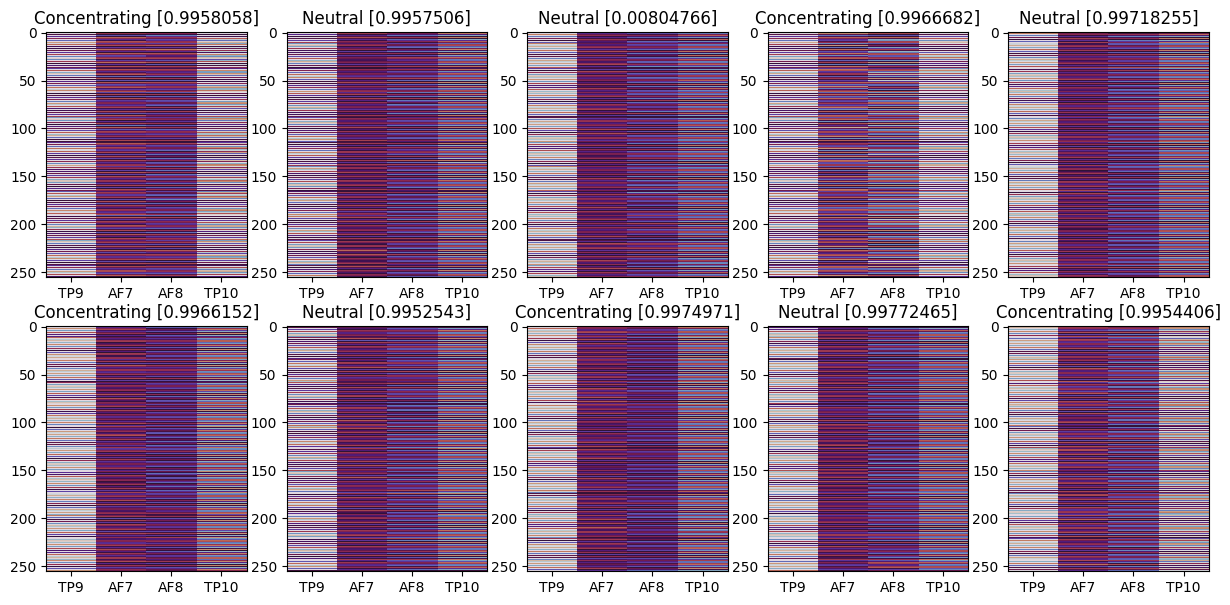

In [26]:

# Assuming X_test_scaled and y_test are already defined, and each image is 2D
fig, axes = plt.subplots(2, 5, figsize=(15, 7))  # Create a 2x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate through it


positives = 0
negatives = 0

i = 20
while positives<2 or negatives<8:

    if (y_train[i] == 1 and positives<5) or (y_train[i] == 0 and negatives<5):
        ax = axes[positives+negatives]  # Select the subplot for the current image
        ax.imshow(X_train_scaled[i], cmap='twilight', interpolation='nearest', aspect='auto')
        ax.set_title(
            f'Concentrating {preds[i]}' if y_train[i]==0 else f'Neutral {preds[i]}'
            )  # Set title with the label
        # ax.axis('off')  # Hide axis for a cleaner look
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(['TP9','AF7','AF8','TP10'])

        positives+=int(y_train[i]==1)
        negatives+=int(y_train[i]==0)

    i+=1

# Show the plot
# plt.savefig('classes_shuffled_data.png')
plt.show()

In [181]:
def plot_sample(sample):
    variables = ['TP9','AF7','AF8','TP10']
    # Number of samples
    num_samples = sample.shape[0]

    # Create a figure with 5 subplots (1 column and 5 rows)
    fig, axes = plt.subplots(4, 1, figsize=(10, 15))

    # Plot each of the 5 variables in separate subplots
    for i in range(sample.shape[1]):
        axes[i].plot(range(num_samples), sample[:, i], label=f'Variable {i+1}')
        axes[i].set_title(f'{variables[i]}')
        axes[i].set_ylabel('Value')
        axes[i].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

1


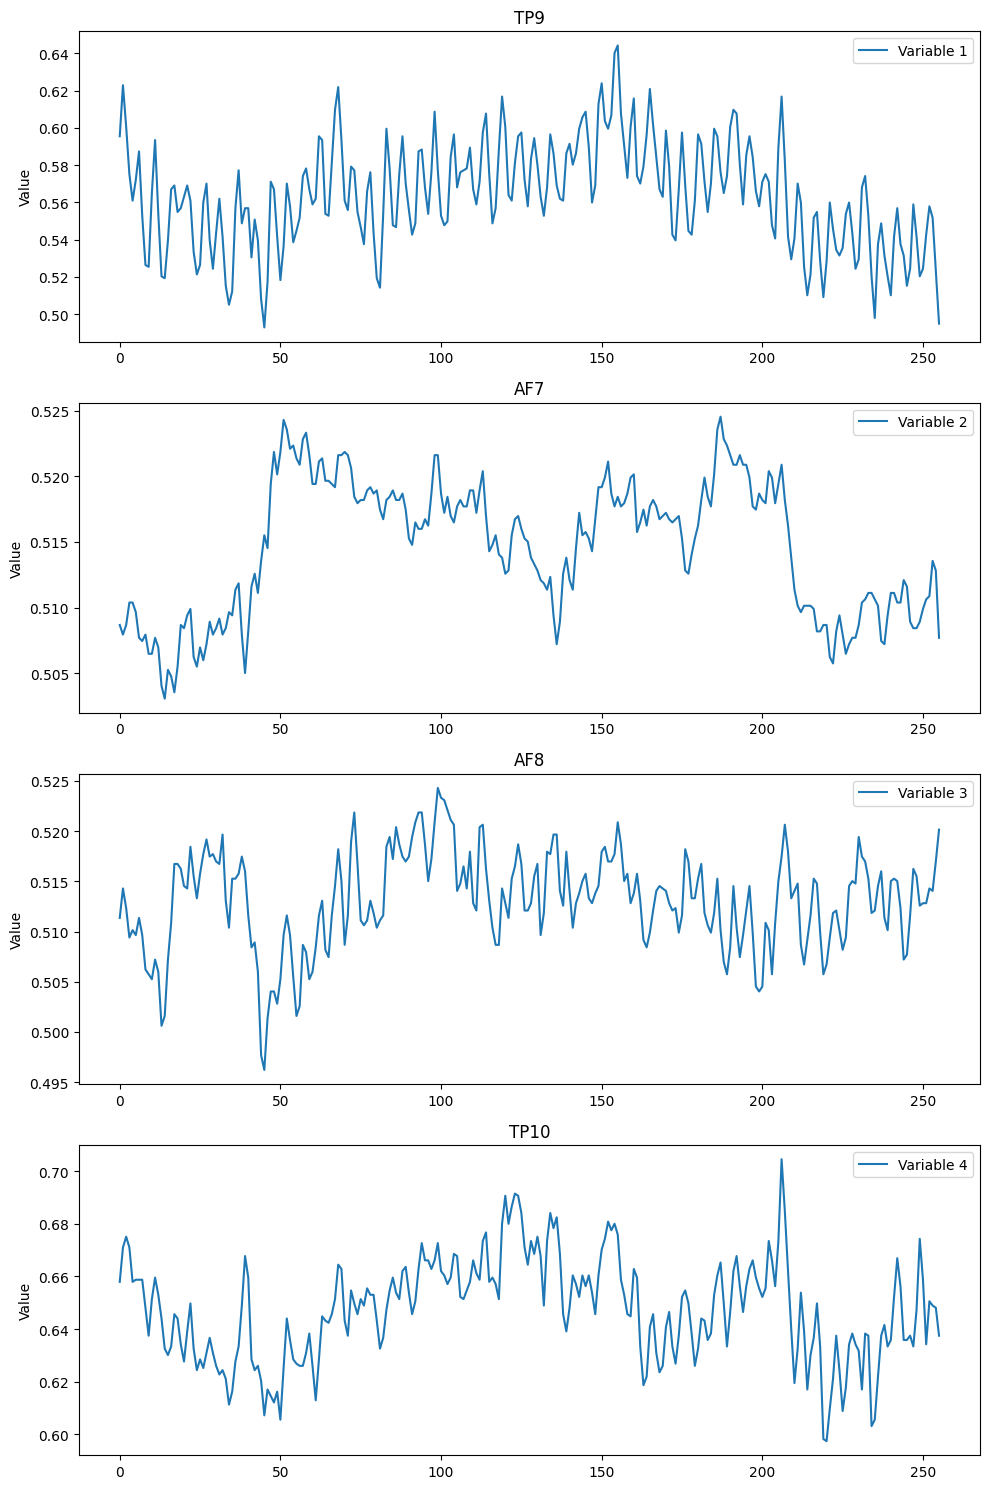

In [186]:
a = 9
print(y_train[a])
plot_sample(X_train_scaled[a])

In [ ]:
eeg_data = X_train_scaled[1]  # Simulated EEG data

eeg_data = eeg_data.reshape(4,256)